# Training Data Preparation

This notebook is used to examine data and remove data before any modeling steps (data partitioning, training, etc.)

- Load all features (from genomes) and phenotypic data
- Selection of features (removes features)
- QC of genomes (removes genomes)
- QC of phenotypic data (removes genomes)
- Save datasets

In [1]:
# edit these files
FEATURES_DIRECTORY = '../data/features/'
BACDIVE_DATA_FILE = '../data/training_data/bacdive_data.json'
TRAINING_DATA_TSV = '../data/training_data/training_data.tsv' #training_data_20231203.tsv'
GTDB_TAXONOMY_TABLE = '../data/references/all_taxonomy_r214.tsv'
HOLDOUT_DIRECTORY = '../data/holdouts/'

In [2]:
import json
from glob import glob
import sys 
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("../")
from genome_spot.model_training.download_trait_data import ComputeBacDiveTraits, load_targets_to_dataframe
from genome_spot.taxonomy.taxonomy import TaxonomyGTDB
from genome_spot.taxonomy.partition import PartitionTaxa
from genome_spot.taxonomy.balance import BalanceTaxa
from genome_spot.helpers import rename_condition_to_variable, load_train_and_test_sets
plt.style.use('project.mplstyle')

## Load data



In [3]:
df = pd.read_csv(TRAINING_DATA_TSV, index_col=0, sep='\t')
df

,all_nt_length,all_pur_pyr_transition_freq,all_nt_C,all_nt_A,all_total_proteins,all_total_protein_length,all_pis_acidic,all_pis_neutral,all_pis_basic,all_pis_3_4,...,facultative aerobe,aerotolerant,microaerotolerant,domain,phylum,class,order,family,genus,species
GCA_003351045,3028597.0,0.536884,0.716499,0.283501,3119.0,914322.0,0.419045,0.264828,0.316127,0.0,...,NaN,NaN,NaN,Bacteria,Actinomycetota,Thermoleophilia,Gaiellales,Gaiellaceae,Gaiella,Gaiella occulta
GCA_900635285,2835267.0,0.501540,0.328374,0.671626,2617.0,785156.0,0.364922,0.304165,0.330913,0.0,...,NaN,NaN,NaN,Bacteria,Bacillota,Bacilli,Staphylococcales,Staphylococcaceae,Staphylococcus,Staphylococcus aureus
GCA_900450125,5062071.0,0.518257,0.505235,0.494765,4684.0,1446017.0,0.292699,0.422289,0.285013,0.0,...,NaN,NaN,NaN,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli
GCA_003258705,5379841.0,0.449242,0.371974,0.628026,4331.0,1597801.0,0.382360,0.366197,0.251443,0.0,...,NaN,NaN,NaN,Bacteria,Bacteroidota,Bacteroidia,Cytophagales,Spirosomaceae,Arcticibacterium,Arcticibacterium luteifluviistationis
GCA_008033445,2665295.0,0.555118,0.716844,0.283156,2473.0,802747.0,0.156490,0.475536,0.367974,0.0,...,NaN,NaN,NaN,Bacteria,Pseudomonadota,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Vulcaniibacterium_B,Vulcaniibacterium_B gelatinicum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_002895005,3049617.0,0.474641,0.354251,0.645749,2739.0,941086.0,0.358525,0.361811,0.279664,0.0,...,NaN,NaN,NaN,Bacteria,Bacteroidota,Bacteroidia,Flavobacteriales,Flavobacteriaceae,Hanstruepera,Hanstruepera neustonica
GCA_000300335,4466307.0,0.517709,0.655115,0.344885,4197.0,1306143.0,0.353109,0.402907,0.243984,0.0,...,NaN,NaN,NaN,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhizobiales,Rhizobiaceae,Nitratireductor,Nitratireductor pacificus
GCA_004339805,4632377.0,0.490578,0.461756,0.538244,4501.0,1365617.0,0.265497,0.474117,0.260387,0.0,...,NaN,NaN,NaN,Bacteria,Bacillota_C,Negativicutes,Sporomusales_C,DSM-15969,Anaerospora,Anaerospora hongkongensis
GCA_000953375,1016762.0,0.445851,0.236659,0.763341,744.0,216589.0,0.122312,0.279570,0.598118,0.0,...,NaN,NaN,NaN,Bacteria,Bacillota,Bacilli,Mycoplasmatales,Mycoplasmataceae,Mycoplasma,Mycoplasma capricolum


In [5]:
cols = df.columns.tolist()
target_cols = cols[cols.index('ncbi_taxid'):]
feature_cols = cols[:cols.index('ncbi_taxid')]

df_features = df[feature_cols]
df_targets = df[target_cols]

### Features (genomic data)

In [13]:
len(df_features)

15596

### Targets (phenotypic data)

In [14]:
# quantitative_vars = sorted(['ph_optimum','ph_optimum_min','ph_optimum_max', 'temperature_optimum','salinity_optimum',  'salinity_midpoint', 'salinity_min', 'salinity_max', 'ph_min', 'ph_max', 'temperature_min', 'temperature_max',])
# df_targets['ncbi_accession'] = [acc.split('.')[0] for acc in df_targets['ncbi_accession']]
# df_targets = df_targets[~df_targets['ncbi_accession'].isnull()].set_index('ncbi_accession')
# df_targets.loc[:, quantitative_vars] = df_targets.loc[:, quantitative_vars].astype(float)
# df_targets = df_targets.rename(columns={'species' : 'ncbi_species'})

# taxonomy = TaxonomyGTDB()
# for taxlevel, index in taxonomy.indices.items():
#     df_targets[taxlevel] = df_targets.index.map({k : v[index] for k, v in taxonomy.taxonomy_dict.items()})


df_targets.head(2)

,ncbi_taxid,strain_id,ncbi_species,ph_optimum,ph_optimum_min,ph_optimum_max,temperature_optimum,salinity_optimum,salinity_midpoint,salinity_min,...,facultative aerobe,aerotolerant,microaerotolerant,domain,phylum,class,order,family,genus,species
GCA_003351045,1002870.0,168557,Gaiella occulta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Bacteria,Actinomycetota,Thermoleophilia,Gaiellales,Gaiellaceae,Gaiella,Gaiella occulta
GCA_900635285,1280.0,14490,Staphylococcus aureus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Bacteria,Bacillota,Bacilli,Staphylococcales,Staphylococcaceae,Staphylococcus,Staphylococcus aureus


In [15]:
df_targets[(df_targets['use_salinity'] == True) & (df_targets['salinity_optimum'] == 0)].shape

(245, 36)

In [16]:
# screen salinity
# 'GCA_003751385', 'GCA_023078355', 'GCA_000956175', 'GCA_000875775'
df_targets[ (df_targets['salinity_optimum'] > 14)][['species', 'family', 'class']].sort_values('family')[:50]

,species,family,class
GCA_001311865,Piscibacillus salipiscarius,Alkalibacillaceae,Bacilli
GCA_000430745,Fictibacillus_A gelatini,Fictibacillaceae,Bacilli
GCA_900156425,Haladaptatus litoreus,Haladaptataceae,Halobacteria
GCA_008831545,Halorussus halophilus,Haladaptataceae,Halobacteria
GCA_000710615,Haladaptatus cibarius,Haladaptataceae,Halobacteria
GCA_900114435,Halomicrobium zhouii,Haloarculaceae,Halobacteria
GCA_004118325,Halorientalis pallida,Haloarculaceae,Halobacteria
GCA_019599515,Halomicroarcula pellucida,Haloarculaceae,Halobacteria
GCA_014647415,Haloarcula sebkhae,Haloarculaceae,Halobacteria
GCA_000379085,Halomicrobium katesii,Haloarculaceae,Halobacteria


In [17]:
too_low = df_targets[ (df_targets['salinity_optimum'] < 3.7) & (df_targets['class'].isin(['Halobacteria']))]
print(too_low.index)
too_low

Index([], dtype='object')


,ncbi_taxid,strain_id,ncbi_species,ph_optimum,ph_optimum_min,ph_optimum_max,temperature_optimum,salinity_optimum,salinity_midpoint,salinity_min,...,facultative aerobe,aerotolerant,microaerotolerant,domain,phylum,class,order,family,genus,species


In [18]:
labels =  {
            "obligate aerobe",
            "aerobe",
            "facultative anaerobe",
            "facultative aerobe",
            "microaerophile",
            "aerotolerant",
    "obligate anaerobe", "anaerobe"}

list(labels)

['aerotolerant',
 'anaerobe',
 'aerobe',
 'obligate aerobe',
 'obligate anaerobe',
 'facultative anaerobe',
 'facultative aerobe',
 'microaerophile']

## QC of genomes

Text(0.5, 1.0, 'Coding Density Filter for Genome Quality')

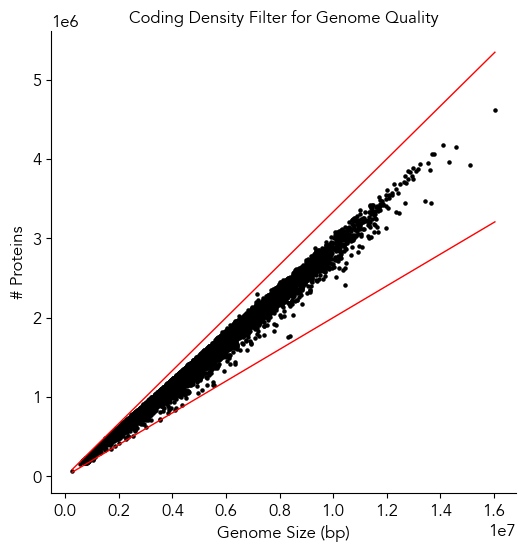

In [21]:

MIN_PROTEIN_CODING_DENSITY = 0.60
MAX_PROTEIN_CODING_DENSITY = 1.

fig, ax = plt.subplots(figsize=(6,6))
X = df_features['all_nt_length'].values
Y = df_features['all_total_protein_length'].values
ax.scatter(X, Y, s= 5)
ax.plot([X.min(), X.max(), ], [0.6*(1/3)*X.min(), 0.6*(1/3)*X.max()], color='red')
ax.plot([X.min(), X.max(), ], [1.0*(1/3)*X.min(), 1.0*(1/3)*X.max()], color='red')
ax.set_xlabel('Genome Size (bp)')
ax.set_ylabel('# Proteins')
ax.set_title('Coding Density Filter for Genome Quality')

## QC of phenotypic data

We want optima and ranges that were well-sampled

In [22]:
targets = ['oxygen', 'ph_optimum', 'salinity_optimum', 'temperature_optimum']
max_fraction = 0.01
for target in targets:
    Y = df_targets[target].dropna()
    value_frequency = (Y.value_counts() / len(Y))
    most_frequent_values = value_frequency[value_frequency > max_fraction].index
    print(target, value_frequency.head(1))
    print(sorted(most_frequent_values))

oxygen oxygen
1.0    0.767671
Name: count, dtype: float64
[0.0, 1.0]
ph_optimum ph_optimum
7.0    0.343477
Name: count, dtype: float64
[6.0, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.5, 9.0]
salinity_optimum salinity_optimum
2.0    0.111532
Name: count, dtype: float64
[0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0, 7.5, 10.0]
temperature_optimum temperature_optimum
28.0    0.20092
Name: count, dtype: float64
[20.0, 25.0, 26.0, 26.5, 27.5, 28.0, 29.0, 30.0, 31.0, 32.5, 33.5, 35.0, 37.0, 40.0]


In [23]:
indices_to_remove = []


taxonomy = TaxonomyGTDB()

rng = np.random.default_rng(0)

def downsample_distribution_cap(Y, bins, max_fraction_per_bin=0.05):
    if bins is None:
        bins = 50
    
    hist, bins = np.histogram(Y, bins=bins)
    if max_fraction_per_bin is None:
        max_fraction_per_bin = len(bins)**-(1/1)
    max_per_bin = int(len(Y) * max_fraction_per_bin)
    
    indices = []
    y_indices = np.array([i for i in range(len(Y))])
    for i, count in enumerate(hist):
        y_bin_indices = y_indices[(Y >= bins[i]) & (Y < bins[i+1])]
        y_sample = rng.choice(y_bin_indices, size=min([len(y_bin_indices), max_per_bin]), replace=False)
        indices.extend(list(y_sample))
        #print(count, y_sample)

    Y_revised = Y[indices]
    return Y_revised

def downsample_most_freq_values(Y, max_fraction = 0.03):

    value_frequency = (Y.value_counts() / len(Y))
    allowed_values = value_frequency[value_frequency < max_fraction].index
    Y_revised = Y[Y.isin(allowed_values)]
    return Y_revised



def downsample_by_balancing(Y, keep=0.5, taxonomy=taxonomy):

    genomes = Y.index.tolist()
    taxonomy = TaxonomyGTDB()
    balancer = BalanceTaxa(taxonomy=taxonomy)
    balanced_genomes = balancer.balance_dataset(
        genomes=genomes,
        proportion_to_keep=keep,
        diversity_rank="species"
    )

    Y_revised = Y.loc[list(balanced_genomes)]
    return Y_revised
    

846 564 0.6666666666666666 0.23737373737373738
0.0
13.555000000000007


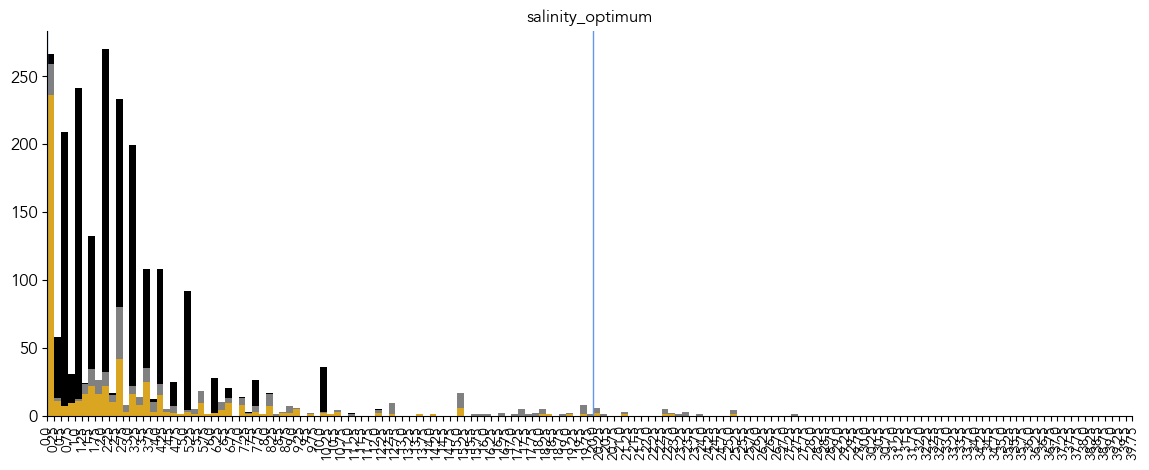

1022 681 0.6663405088062623 0.19188503803888418
4.33
9.5


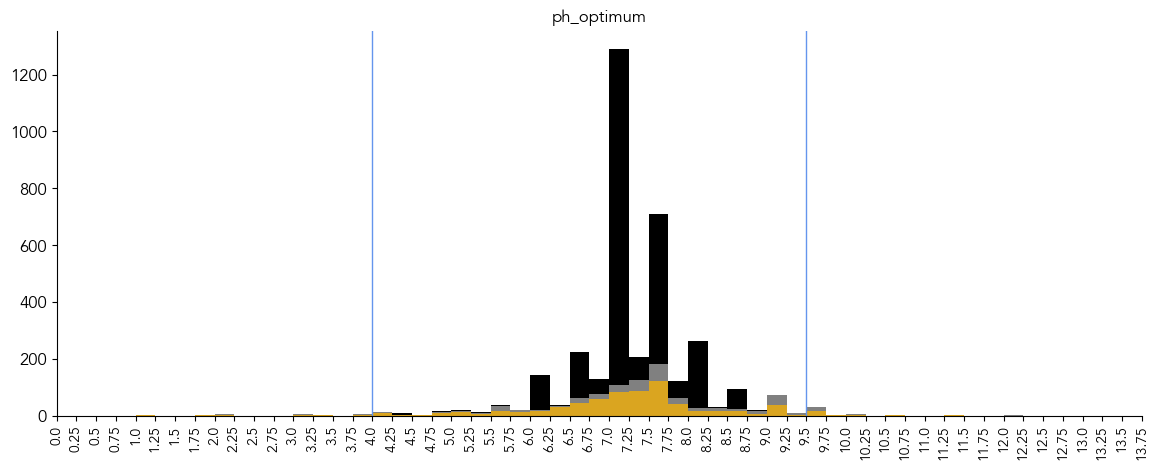

2420 1613 0.6665289256198347 0.33723604432364623
16.0
65.0


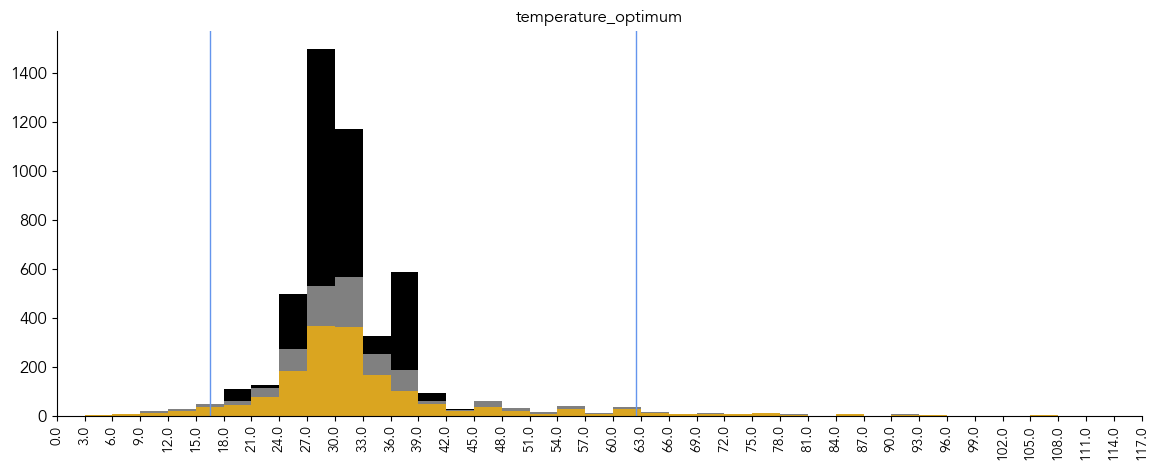

In [24]:

def ax_histograms_downsampling(ax, target, bin_min, bin_max, bin_step):
    bins = np.arange(bin_min, bin_max, bin_step)
    
    X1 = df_targets[target].dropna()
    X = df_targets.loc[df_targets[f"use_{target.replace('_optimum','')}"] == True, target].dropna()
    #X2 = downsample_distribution_cap(X, bins=50)
    X2 = downsample_by_balancing(X, keep=2/3)
    print(len(X), len(X2), len(X2)/len(X), len(X2)/len(X1))
    print(np.percentile(X2, 3))
    print(np.percentile(X2, 97))
    counts, bins, _ = ax.hist(X1, bins=bins, color='black')
    _, _, _ = ax.hist(X, bins=bins, color='gray')
    _, _, _ = ax.hist(X2, bins=bins, color='goldenrod')
    ax.set_xlim([min(bins), max(bins)])
    ax.set_xticks(bins)
    ax.set_xticklabels(bins, rotation=90, fontsize=10)
    ax.set_title(target)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_yscale('log')
    for perc in [3, 97]:
        ax.axvline(np.percentile(X.values, perc), color='cornflowerblue')


target = 'salinity_optimum'
bin_min, bin_max, bin_step = 0,40,0.25
fig , ax = plt.subplots(figsize=(14,5))
ax_histograms_downsampling(ax, target, bin_min, bin_max, bin_step)
plt.show()

target = 'ph_optimum'
bin_min, bin_max, bin_step = 0, 14, 0.25
fig , ax = plt.subplots(figsize=(14,5))
ax_histograms_downsampling(ax, target, bin_min, bin_max, bin_step)
plt.show()


target = 'temperature_optimum'
bin_min, bin_max, bin_step = 0,120,3
fig , ax = plt.subplots(figsize=(14,5))
ax_histograms_downsampling(ax, target, bin_min, bin_max, bin_step)
plt.show()

# Check train/test splits

Must run `make_holdout_sets.py` beforehand

In [29]:
from genome_spot.helpers import rename_condition_to_variable, prepend_features, split_train_and_test_data, load_train_and_test_sets, load_cv_sets

PATH_TO_HOLDOUTS = '../data/holdouts'

In [56]:
# Supplementary data 2
# oxygen, ....
# test, train, cv1, cv2, cv3, cv4, cv5

conditions = ['oxygen', 'temperature', 'salinity', 'ph']

dfs = []
for condition in conditions:

    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    target = rename_condition_to_variable(condition)
    partition_rank = 'family'
    cv_sets = load_cv_sets(condition,PATH_TO_HOLDOUTS, partition_rank)
    
    indexers = {
        'test' : test_set,
        'train' : train_set,
        'cv_test1' : cv_sets[0][1],
       'cv_test2' : cv_sets[1][1],
       'cv_test3' : cv_sets[2][1],
       'cv_test4' : cv_sets[3][1],
       'cv_test5' : cv_sets[4][1],
    }
    
    sers = []
    for name, index in indexers.items():
    
        if name.startswith('cv'):
            # indexed by number
            value_counts = df_targets.loc[train_set].iloc[index]['family'].value_counts()
        else:
            value_counts = df_targets.loc[index]['family'].value_counts()
        value_counts.name = name
        sers.append(value_counts)
    
    results_df = pd.concat(sers, axis=1).T
    results_df['condition'] = condition
    results_df = results_df.set_index(['condition', results_df.index])
    results_df = results_df.T
    #results_df.name = condition
    dfs.append(results_df)

holdouts_summary = pd.concat(dfs, axis=1).fillna(0).astype(int)
holdouts_summary = holdouts_summary.loc[holdouts_summary.sum(axis=1).sort_values(ascending=False).index]
holdouts_summary.to_csv('supplementary_data_2.tsv', sep='\t')
holdouts_summary.head(30)

condition           oxygen                                                     \
                      test train cv_test1 cv_test2 cv_test3 cv_test4 cv_test5   
family                                                                          
Flavobacteriaceae      225     0        0        0        0        0        0   
Burkholderiaceae         0   114        0        0      114        0        0   
Rhodobacteraceae       111     0        0        0        0        0        0   
Pseudomonadaceae         0   103        0      103        0        0        0   
Rhizobiaceae             0    91        0       91        0        0        0   
Sphingomonadaceae      127     0        0        0        0        0        0   
Streptomycetaceae        0    74        0        0        0        0       74   
Burkholderiaceae_B       0    78        0        0        0       78        0   
Enterobacteriaceae       0    86       86        0        0        0        0   
Sphingobacteriaceae      0    51        0        0        0       51        0   
Microbacteriaceae        0    42       42        0        0        0        0   
Bacteroidaceae           0    96        0        0        0       96        0   
Lachnospiraceae          0    92        0        0       92        0        0   
Weeksellaceae            0    41        0       41        0        0        0   
Chitinophagaceae         0    51        0       51        0        0        0   
Mycobacteriaceae         0    36       36        0        0        0        0   
Alteromonadaceae         0    29        0        0        0        0       29   
Cyclobacteriaceae        0    30        0       30        0        0        0   
Beijerinckiaceae         0    36        0        0        0        0       36   
Haloferacaceae          31     0        0        0        0        0        0   
Desulfovibrionaceae      0    46        0       46        0        0        0   
Deinococcaceae           0    31        0        0       31        0        0   
Xanthomonadaceae        38     0        0        0        0        0        0   
Moraxellaceae            0    37        0        0        0        0       37   
Halomonadaceae           0    23       23        0        0        0        0   
Pseudonocardiaceae       0     8        0        0        8        0        0   
Micromonosporaceae       0    14        0       14        0        0        0   
Vibrionaceae             0    21        0        0        0        0       21   
Campylobacteraceae       0    46        0        0        0        0       46   
Spirosomaceae            0    27        0       27        0        0        0   

condition           temperature                 ... salinity           \
                           test train cv_test1  ... cv_test3 cv_test4   
family                                          ...                     
Flavobacteriaceae             0   143        0  ...        0        0   
Burkholderiaceae              0    52        0  ...        0        0   
Rhodobacteraceae              1    77        0  ...        0       25   
Pseudomonadaceae              0    29       29  ...        0        0   
Rhizobiaceae                  0    33       33  ...        0        0   
Sphingomonadaceae            68     0        0  ...        0        0   
Streptomycetaceae             0    30        0  ...        0        0   
Burkholderiaceae_B            0    29        0  ...        0        0   
Enterobacteriaceae            0    21        0  ...        0        0   
Sphingobacteriaceae           0    33        0  ...        0        0   
Microbacteriaceae             0    45        0  ...        0        0   
Bacteroidaceae                0     5        0  ...        0        0   
Lachnospiraceae               0     5        0  ...        0        0   
Weeksellaceae                 0    27        0  ...        0        0   
Chitinophagaceae             28     0        0  ...        0        6   
Mycobacteria

oxygen
test     0.0
train    0.0
dtype: float64

temperature_optimum
test     0.153179
train    0.139535
dtype: float64

salinity_optimum
test     0.0
train    0.0
dtype: float64

ph_optimum
test     0.032680
train    0.011609
dtype: float64

919 2727


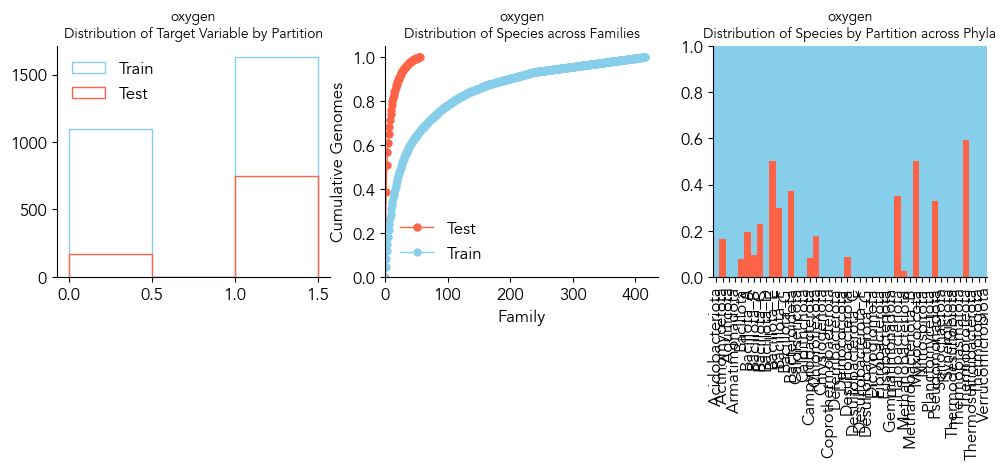

138 571


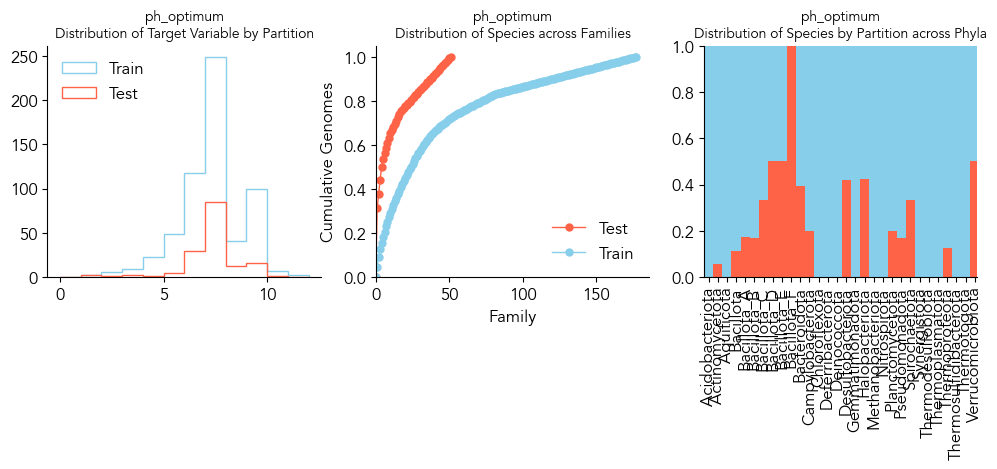

109 444


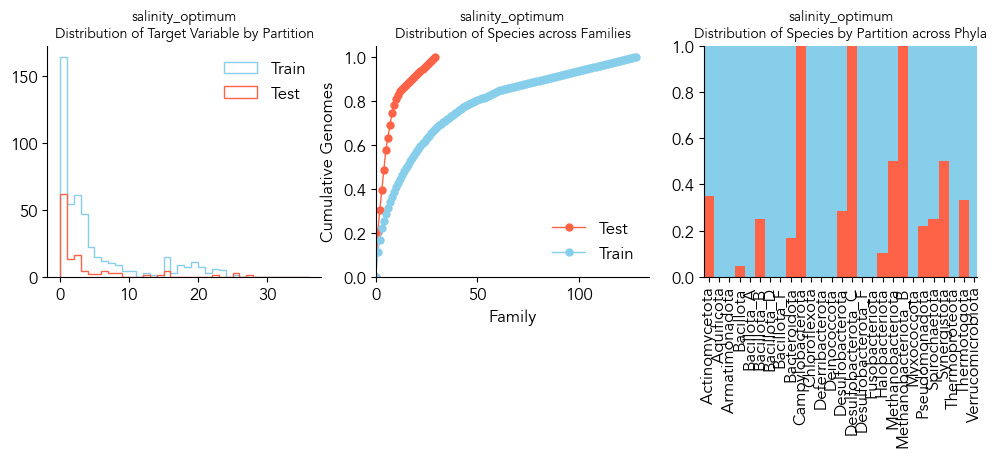

302 1264


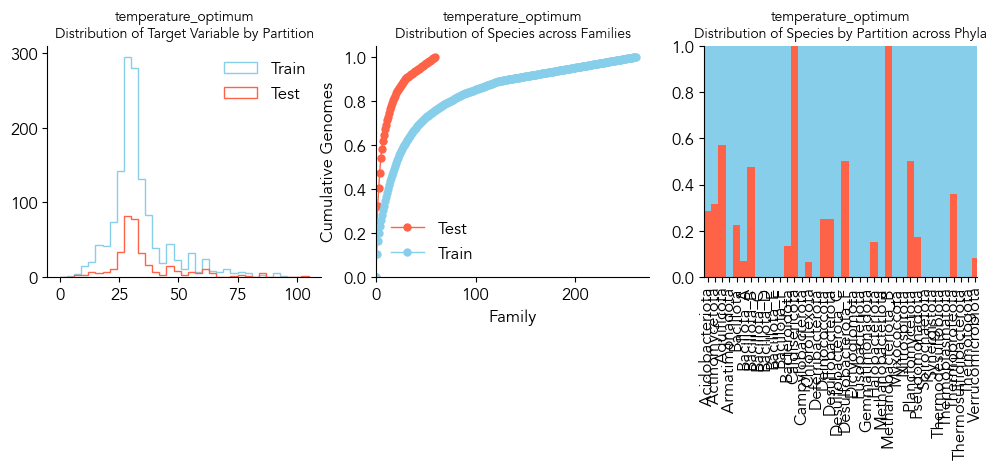

In [58]:
conditions = ['oxygen', 'temperature', 'salinity', 'ph']
taxonomy = TaxonomyGTDB()
from collections import Counter

for condition in conditions:
    target = rename_condition_to_variable(condition)
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    
    genome_to_taxlevel = taxonomy.taxonomy_dict_at_taxlevel(taxlevel='family')
    test_ser = pd.Series(Counter([genome_to_taxlevel.get(genome, None) for genome in test_set]))
    test_ser.name = 'test'
    train_ser = pd.Series(Counter([genome_to_taxlevel.get(genome, None) for genome in train_set]))
    train_ser.name = 'train'
    
    holdout_df = pd.concat([test_ser, train_ser], axis=1)
    holdout_df[(holdout_df['test'] > 0) & (holdout_df['train'] > 0)].sum()
    
    print(target)
    print(holdout_df[(holdout_df['test'] > 0) & (holdout_df['train'] > 0)].sum() / holdout_df.sum())
    print()
    
HOLDOUT_DIRECTORY = '../data/holdouts/'

test_color = 'tomato'
train_color = 'skyblue'
balancer = BalanceTaxa(taxonomy=taxonomy)

partitioner = PartitionTaxa(
        taxonomy=taxonomy,
        partition_rank='family',
        diversity_rank='genus',
    )

for condition, bins in [
   ('oxygen', np.arange(0,2,0.5)),
                       ('ph',  np.arange(0,13,1)),
                       ('salinity', np.arange(0,37,1)),
                       ('temperature', np.arange(0,107,3)),
                 ]:

    
    target = rename_condition_to_variable(condition)
    train_set, test_set = load_train_and_test_sets(condition, PATH_TO_HOLDOUTS)
    train_set = set(train_set)
    test_set = set(test_set)
    test_set_present = test_set.intersection(set(df[df[f'use_{target_type}'] == True].index.tolist()))
    train_set_present = train_set.intersection(set(df[df[f'use_{target_type}'] == True].index.tolist()))
    print(len(test_set_present), len(train_set_present))
    proportion_dict = balancer.assess_proportion(subset_genomes=test_set_present, reference_genomes=test_set_present.union(train_set_present), rank='phylum')
    test_diversity = taxonomy.measure_diversity(query_rank='family', diversity_rank='species', subset_genomes=list(test_set_present))
    train_diversity = taxonomy.measure_diversity(query_rank='family', diversity_rank='species', subset_genomes=list(train_set_present))


                     
    fig, axes = plt.subplots(1,3, figsize=(12,3))
    
    ax = axes[1]
    X1 = [0] + list(pd.DataFrame.from_dict(test_diversity, orient='index').sort_values(by=0, ascending=False)[0].values)
    X2 = [0] + list(pd.DataFrame.from_dict(train_diversity, orient='index').sort_values(by=0, ascending=False)[0].values)
    ax.set_title(f"{target}\nDistribution of Species across Families", fontsize=10)
    ax.plot(range(len(X1)), np.cumsum(X1) / np.sum(X1), marker='.', color=test_color, label='Test')
    ax.plot(range(len(X2)), np.cumsum(X2) / np.sum(X2), marker='.', color=train_color, label='Train')
    ax.set_ylabel('Cumulative Genomes')
    ax.set_xlabel('Family')
    ax.legend(frameon=False)
    
    # ax.barh(range(len(X)), X, height=1, color=test_color, edgecolor='black')
    # ax.set_yticks(range(len(X)))
    # ax.set_yticklabels(df_counts.index.tolist())
    #ax.set_ylim([0,1])
    ax.legend(frameon=False)
    ax.set_ylim([0,ax.get_ylim()[1]])
    ax.set_xlim([0,ax.get_xlim()[1]])
    
    ax = axes[0]
    
    ax.set_title(f"{target}\nDistribution of Target Variable by Partition", fontsize=10)
    X_test = df.reindex(test_set)[target].values
    X_train = df.reindex(train_set)[target].values
    hist_params = {'bins' : bins, 'density' : False, 'histtype' : 'step'}
    ax.hist(X_train, color=train_color, label='Train', **hist_params)
    ax.hist(X_test, color=test_color, label='Test',  **hist_params)
    ax.legend(frameon=False)
    ax.set_label(target)
    #ax.set_ylim([0.0001,1])
    #ax.set_yscale('log')
    
    
    ax = axes[2]
    df_counts = pd.DataFrame.from_dict(proportion_dict, orient='index').sort_index()
    df_counts.columns = ['Test']
    df_counts['Train'] = 1 - df_counts['Test']
    ax.set_title(f"{target}\nDistribution of Species by Partition across Phyla", fontsize=10)
    df_counts.plot.bar(ax=ax, width=1, color=[test_color, train_color], edgecolor='None', stacked=True, legend=False)
    ax.set_ylim([0,1])
    ax.set_xlim([-0.5,ax.get_xlim()[1]-0.45])
    
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    plt.show() 